# Applied Statistical Learning in Python

## Sample Code: Lung Cancer Diagnosis

You are given a dataset of 1105 chest X-ray (CXR) images, each described by 102 attributes and a label, where 1 indicates malignant lung cancer, and 0 indicates benign tumour. Your task is to build a classification model to predict whether a given CXR shows a malignant or benign tumour.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation

In [2]:
# load and inspect the data
data = pd.read_csv('lungsample.csv')
data.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v93,v94,v95,v96,v97,v98,v99,v100,v101,label
0,3.639636,1.228248,0.110404,-1.003732,-1.102129,-1.011640,-0.106856,-0.630868,-1.126608,-0.048744,...,-1.405700,0.033063,0.092675,2.071139,-1.159186,0.285666,1.691165,-0.413781,-1.577695,0
1,-0.164889,0.401110,0.555741,0.083018,1.248687,0.419196,-0.132630,-1.011638,1.189815,-0.558548,...,0.990005,-0.234665,0.486476,0.156383,-0.079373,-0.167362,-0.581883,-0.981381,0.772401,0
2,0.466852,-0.362214,0.290673,0.358680,0.288683,0.169915,-0.130182,0.823796,0.271589,1.069925,...,0.685890,0.035272,0.249075,-0.584769,-0.635233,0.389731,-0.506207,-0.706763,-0.805263,0
3,-0.385892,-1.351414,1.010566,-1.212319,-1.914623,-1.130040,-0.014538,-0.587020,-1.906679,1.019006,...,-1.878473,0.494254,0.856842,2.750338,0.224587,0.470562,2.985488,-1.552287,1.107159,0
4,-0.188841,0.987212,-0.480216,0.162236,0.687001,-0.090172,-0.113926,-0.618971,0.607489,-0.471608,...,0.734663,-0.070419,-0.408618,1.122769,-1.219642,-0.058283,-0.431281,0.116943,1.555012,0


In [3]:
data.shape

(1105, 103)

In [4]:
# prepare predictor and response arrays from data
x = data.values[:, 0:102]
y = data.values[:, 102]
print ('x:', x.shape)
print ('y:', y.shape)

x: (1105, 102)
y: (1105,)


<i>I will now split the data into training (70%) and testing (30%) sets, and check that their dimensions are correct.</i>

In [5]:
# split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

# sanity check
print ('Train set: ', x_train.shape)
print ('Test set: ', x_test.shape)
print ('Train benign: {}, Train malignant: {}'.format(len(y_train[y_train==0]), len(y_train[y_train==1])))
print ('Test benign: {}, Test malignant: {}'.format(len(y_test[y_test==0]), len(y_test[y_test==1])))

Train set:  (773, 102)
Test set:  (332, 102)
Train benign: 481, Train malignant: 292
Test benign: 194, Test malignant: 138


## Model Building

<i>I will now proceed to train 2 classifiers using random forest and support vector machine, and evaluate their performance using test accuracy, sensitivity and specificity.</i>

In [6]:
# function for computing the overall test accuracy, sensitivity and specificity of a given model
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['Overall test accuracy', 'Accuracy on benign (Specificity)', 'Accuracy on malignant (Sensitivity)'])

In [7]:
# random forest
rf = RandomForestClassifier(class_weight='balanced', n_estimators=30)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)

# svm
svm = SVC(class_weight='balanced')
svm.fit(x_train, y_train)
svm_scores = score(svm, x_test, y_test)

# present scores in a dataframe
score_df = pd.DataFrame({'Random Forest': rf_scores, 'SVM': svm_scores})
score_df

,Random Forest,SVM
Overall test accuracy,0.858434,0.849398
Accuracy on benign (Specificity),0.912371,0.871134
Accuracy on malignant (Sensitivity),0.782609,0.818841


## Parameter Tuning

<i>Now, I will try to tune the parameters of the random forest and SVM models, and see if they can perform better. For random forest, I will use 5-fold cross-validation to find the best max depth of trees. For SVM, I will use 5-fold cross-validation to find the best regularization parameter C.</i>

In [8]:
# tune random forest
parameters = {'max_depth': range(1, 10)}
rf = RandomForestClassifier(class_weight='balanced', n_estimators=30)
rf_tuned = GridSearchCV(rf, parameters, cv=5)
rf_tuned.fit(x_train, y_train)
print ('Test accuracy for random forest model with {}: {}'.format(rf_tuned.best_params_, score(rf_tuned, x_test, y_test)[0]))

Test accuracy for random forest model with {'max_depth': 6}: 0.8463855421686747


In [9]:
# tune svm
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
svm = SVC(class_weight='balanced', kernel='linear')
svm_tuned = GridSearchCV(svm, parameters, cv=5)
svm_tuned.fit(x_train, y_train)
print ('Test accuracy for SVM model with {}: {}'.format(svm_tuned.best_params_, score(svm_tuned, x_test, y_test)[0]))

Test accuracy for SVM model with {'C': 0.1}: 0.8554216867469879


## Model Evaluation

<i>Now, I will plot the Receiver Operating Characteristic (ROC) curves for the 2 models to compare their areas under the curve.</i>

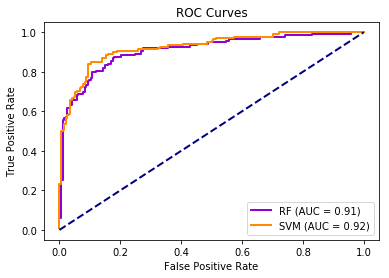

In [10]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# random forest
rf = RandomForestClassifier(class_weight='balanced', n_estimators=30, max_depth=6)
rf_probas = rf.fit(x_train, y_train).predict_proba(x_test)
fpr["RF"], tpr["RF"], _ = roc_curve(y_test, rf_probas[:, 1])
roc_auc["RF"] = auc(fpr["RF"], tpr["RF"])

# svm
svm = SVC(class_weight='balanced', kernel='linear', C=0.1)
svm_probas = svm.fit(x_train, y_train).decision_function(x_test)
fpr["SVM"], tpr["SVM"], _ = roc_curve(y_test, svm_probas)
roc_auc["SVM"] = auc(fpr["SVM"], tpr["SVM"])

# plot
plt.figure()
plt.plot(fpr["RF"], tpr["RF"], color='darkviolet', lw=2, label='RF (AUC = %0.2f)' % roc_auc["RF"])
plt.plot(fpr["SVM"], tpr["SVM"], color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % roc_auc["SVM"])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

<i>I will now visualize the top 5 most predictive features and their relative importance in the random forest model.</i>

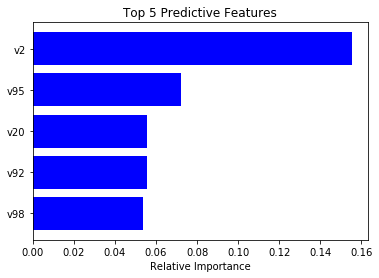

In [11]:
# obtain feature importance list and sort
importances = rf.feature_importances_
indices = np.argsort(importances)
top5_indices = indices[-5:]

# extract gene names
features = data.columns

# plot
plt.title('Top 5 Predictive Features')
plt.barh(range(len(top5_indices)), importances[top5_indices], color='blue', align='center')
plt.yticks(range(len(top5_indices)), features[top5_indices])
plt.xlabel('Relative Importance')
plt.show()